In [80]:
%matplotlib inline
from matplotlib import pyplot as plt
import sys
sys.path.append('..')
import treadmill_dataset
from treadmill_dataset import SimpleFrameDataset, SimpleRandomFrameSampler

import pandas as pd
import numpy as np
import torchvision
import imageio
import torch
import os
import re

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
from random import shuffle
from rhodin.python.utils import datasets as rhodin_utils_datasets
from rhodin.python.utils import io as rhodin_utils_io
from tqdm import tqdm

import importlib
importlib.reload(treadmill_dataset)

<module 'treadmill_dataset' from '../treadmill_dataset.py'>

In [81]:
config_dict_module = rhodin_utils_io.loadModule("../configs/config_pose_debug.py")
config_dict = config_dict_module.config_dict
print (config_dict['save_every'])
train_subjects = ['ART', 'HOR', 'LAC', 'LAR', 'LAZ', 'LEA', 'LOR', 'PRA']
config_dict['train_subjects'] = train_subjects
config_dict['dataset_folder_train_mocap'] = '/Midgard/home/sbroome/lameness/treadmill_lameness_mocap_ci_may11/mocap/'
config_dict['dataset_folder_train_rgb'] = '/Midgard/home/sbroome/lameness/animals_data/'

100000


### Look at the .mat data

In [89]:
import scipy.io as scio
big_list = []

def get_frame_inds_for_clip(clip_id):
    """ args clip_id: str
        Give list of RGB frame indices from the animals_data dir.
        return frame_inds: [int]
    """
    # The RGB frames (.png-files) are in animals_data/[clip_id]/[clip_id]_01/
    path = os.path.join(config_dict['dataset_folder_train_rgb'], clip_id, clip_id+'_01')
    frame_inds = []
    for filename in os.listdir(path):
        if filename.endswith(".png"):
            frame_ind = int(filename[5:9])
            frame_inds.append(frame_ind)
    return frame_inds

for filename in os.listdir(config_dict['dataset_folder_train_mocap']):
    if filename.endswith(".mat"):
        subject = filename[:3]
        clip_id = filename[:-4]
        mocap = scio.loadmat(os.path.join(config_dict['dataset_folder_train_mocap'], filename))
        path_annotation = os.path.join(config_dict['dataset_folder_train_mocap'][:-6], 'total_infor_each_video')
        print('Path to annotation .mat-file: ', path_annotation)
        annotation = scio.loadmat(os.path.join(path_annotation,'{}_total_infor.mat'.format(clip_id)))
        frame_index_for_mocap = annotation['horse']['start_frame'][0][0]-1
        frame_index_for_mocap = frame_index_for_mocap[0] # Nested list
        first_frame = int(annotation['horse']['start_image'][0][0][0].split('.')[0][5:])
        rgb_frame_inds = get_frame_inds_for_clip(clip_id)
        print('Mocap frame index: ', frame_index_for_mocap)
        print('Start frame RGB: ', first_frame)
        print('Number of mocap frames: ', len(frame_index_for_mocap))
        print('Number of RGB frames: ', len(rgb_frame_inds))
        for idx, fi in enumerate(frame_index_for_mocap):
            # fi is mocap ind (between 0~5000, idx is rgb ind (just range(~502))
            rgb_idx = first_frame + idx
            row_list = [clip_id, fi, rgb_idx]
            big_list.append(row_list)

Path to annotation .mat-file:  /Midgard/home/sbroome/lameness/treadmill_lameness_mocap_ci_may11/total_infor_each_video
Mocap frame index:  [   6   16   26   36   46   56   66   77   87   97  108  118  128  138
  149  159  169  179  190  200  211  221  231  241  252  262  272  282
  293  303  313  324  334  344  354  364  374  385  395  405  415  425
  435  445  456  467  477  487  497  508  518  528  538  548  558  568
  578  589  600  610  620  630  640  651  661  671  681  691  702  713
  724  734  744  754  764  774  784  795  806  816  826  836  847  857
  867  877  887  897  908  918  928  938  948  958  968  979  989  999
 1010 1020 1030 1040 1050 1060 1070 1081 1091 1102 1113 1123 1134 1144
 1154 1164 1174 1185 1195 1205 1215 1225 1236 1246 1256 1266 1276 1286
 1296 1306 1317 1327 1338 1348 1359 1369 1379 1389 1399 1409 1419 1430
 1440 1450 1461 1471 1481 1491 1502 1512 1522 1532 1542 1552 1562 1572
 1583 1594 1604 1614 1624 1634 1644 1655 1666 1676 1686 1697 1707 1717
 1727 173

### Inspect the mocap data

(51, 3, 5120)


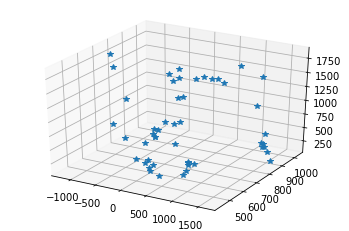

In [90]:
import scipy.io as scio
from mpl_toolkits import mplot3d
counter = 0
for subject in train_subjects:
    for filename in os.listdir(config_dict['dataset_folder_train_mocap']):
        if filename.startswith(subject) and filename.endswith(".mat"):
            while counter < 1:
                mocap = scio.loadmat(os.path.join(config_dict['dataset_folder_train_mocap'], filename))
                clip_id = filename[:-4]
                mocap  = mocap[clip_id]['Trajectories'][0][0][0][0][0][0]['Data'][0]
                mocap = mocap[:,:3,:]
                print(mocap.shape)
                fig = plt.figure()
                ax = plt.axes(projection='3d')
                ax.plot3D(mocap[:,0,0], mocap[:,1,0], mocap[:,2,0], '*')
                row_list = [subject]
                counter += 1

In [91]:
len(big_list)

80764

In [92]:
big_list[:5]

[['ARTqt_iFt1_R120', 6, 4],
 ['ARTqt_iFt1_R120', 16, 5],
 ['ARTqt_iFt1_R120', 26, 6],
 ['ARTqt_iFt1_R120', 36, 7],
 ['ARTqt_iFt1_R120', 46, 8]]

In [93]:
column_headers = ['clip_id', 'mocap_index', 'rgb_index']

In [94]:
df = pd.DataFrame(big_list, columns=column_headers)

In [95]:
df.head()

,clip_id,mocap_index,rgb_index
0,ARTqt_iFt1_R120,6,4
1,ARTqt_iFt1_R120,16,5
2,ARTqt_iFt1_R120,26,6
3,ARTqt_iFt1_R120,36,7
4,ARTqt_iFt1_R120,46,8


In [96]:
len(df)

80764

# Save the frame index

In [97]:
df.to_csv('../../metadata/treadmill_frame_index.csv')